# Assignment 1, programming part
#### IFT 6135
#### February 17, 2019 23:59
#### Authors: Leo Boisvert(20032421), Andrew Williams(20125276)
#### Link to github repository: 

## Import dataset 

In [227]:
# import utils.mnist_reader as mnist_reader
import pickle
import gzip

filepath = r'C:\Users\User\Desktop\UDEM\IFT6135H19_assignment-master\mnist.pkl.gz'

f = gzip.open(filepath, 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [228]:
X_train, y_train = train_set
X_test, y_test = test_set
X_valid, Y_valid = valid_set

# Building the Model

In [229]:
import time
import random
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd

class NN(object):
    
    def __init__(self, d, d_h,d_h2, m, hidden_dims=(512,512),n_hidden=2,mode='train', datapath=None,model_path=None):
        self.m = m
        self.d_h = d_h
        self.hidden_dims = hidden_dims
        self.n_hidden = n_hidden
        self.mode = mode
        self.datapath = datapath
        self.model_path = model_path
        self.binary_y = 0
        
        #parameters
        self.W1 = np.zeros((d_h, d))
        self.W2 = np.zeros((d_h2, d_h))
        self.W3 = np.zeros((m, d_h2))
        
        self.b1 = np.zeros((d_h, 1))
        self.b2 = np.zeros((d_h2, 1))
        self.b3 = np.zeros((m, 1))
        
        #activations
        self.os = 0   
        self.oa = 0   
        
        self.hs1 = 0   
        self.ha1 = 0   
        
        self.hs2 = 0 
        self.ha2 = 0
        
        #gradients
        self.dW1 = np.zeros((d_h, d))
        self.dW2 = np.zeros((d_h2, d_h))
        self.dW3 = np.zeros((m, d_h2))
        
        self.db1 = np.zeros((d_h, 1))
        self.db2 = np.zeros((d_h2, 1))  
        self.db3 = np.zeros((m, 1))
        
        #losses and missclassification rates
        self.loss_train =[]
        self.missclass_train = []
        
        self.loss_valid = []
        self.missclass_valid = []
        
        self.loss_test = []
        self.missclass_test = []
        
        
    def initialize_weights(self, n_hidden=2, dims=(784,10), initialization = None):
        if initialization == None:
            pass
            
        if initialization == 'normal':
            self.W1 = np.random.normal(0,1 , (self.hidden_dims[0],dims[0]))
            self.W2 = np.random.normal(0,1 , (self.hidden_dims[1],self.hidden_dims[0]))
            self.W3 = np.random.normal(0,1 , (dims[1],self.hidden_dims[1]))
            
        if initialization == 'glorot':
            self.W1 = np.random.uniform((-1*np.sqrt(6/(784+512))),(np.sqrt(6/(784+512))), \
                                        (self.hidden_dims[0],dims[0]))
            self.W2 = np.random.uniform((-1*np.sqrt(6/(512+512))),(np.sqrt(6/(512+512))), \
                                        (self.hidden_dims[1],self.hidden_dims[0]))
            self.W3 = np.random.uniform((-1*np.sqrt(6/(10+512))),(np.sqrt(6/(10+512))), \
                                        (dims[1],self.hidden_dims[1]))
    
    
    def forward(self, X):        
        #first layer prop
        self.ha = np.dot(self.W1, X.T) + self.b1
        self.hs = self.activation(self.ha)
        
        #second layer prop
        self.ha2 = np.dot(self.W2, self.hs) + self.b2
        self.hs2 = self.activation(self.ha2)
        
        #third layer prop
        self.oa = np.dot(self.W3, self.hs2) + self.b3
        self.os = self.softmax()
     
    
    def activation(self, fct):
        activation = [[max(0, i) for i in row] for row in fct]
        return np.array(activation)
    
    
    def loss(self, X, Y):
        t = self.getbinary(Y)
        self.forward(X)
        K = self.os.shape[1]
        if K == t.shape[1]:
            return -1 * self.m * np.mean(t * np.log(self.os))
        else :
          print("The subset of example is not consistent between X and Y")             
    
    
    def softmax(self):
        shift = np.max(self.oa, axis = 0)
        shifted_output = self.oa - shift
        normal = np.sum(np.exp(shifted_output), axis = 0)
        return np.exp(shifted_output) / normal
    
    
    def backward(self, X, Y, lamb = np.zeros((3, 2))):
        t = self.getbinary(Y)
        K = X.shape[0]
        
        if K == t.shape[1]:
            #backprop through activation
            doa = self.os - t     # (m, K)
            self.dW3 = 1 / K * np.dot(doa, self.hs2.T)   # (m, d_h)
            self.db3 = np.mean(doa, axis = 1, keepdims = True)  # (m, 1)
            
            #backprop through second hidden layer
            dha2 = np.dot(self.W3.T, doa) * self.positive(self.ha2) 
            self.dW2 = 1 / K * np.dot(dha2, self.hs.T)
            self.db2 = np.mean(dha2, axis = 1, keepdims = True)
            
            #backprop through first hidden layer
            dha = np.dot(self.W2.T, dha2) * self.positive(self.ha)  # (d_h, K)
            self.dW1 = 1 / K * np.dot(dha, X)
            self.db1 = np.mean(dha, axis = 1, keepdims = True)  #(d_h, 1)
            
            #regularization
            self.dW3 += lamb[0][0]*np.sign(self.W3) + 2 * lamb[0][1] * self.W3
            self.dW2 += lamb[1][0]*np.sign(self.W2) + 2 * lamb[1][1] * self.W2
            self.dW1 += lamb[2][0]*np.sign(self.W1) + 2 * lamb[2][1] * self.W1
              
        else:
            print("The subset of example is not consistent between X and Y")
    
    
    def update(self, eta):
        self.W3 -= eta * self.dW3
        self.b3 -= eta * self.db3
        
        self.W2 -= eta * self.dW2
        self.b2 -= eta * self.db2
        
        self.W1 -= eta * self.dW1
        self.b1 -= eta * self.db1
                
                
    def train(self, X, Y, K, eta=0.07, epsilon=1e-3, max_ite=50000, X_valid=np.array([]), Y_valid=np.array([]), \
              n_rep_early_stopping=2, print_loss = False, lamb = np.zeros((3, 2)), X_test=[], \
              Y_test=[], print_graphs= False, initialization = 'glorot'):
        
        #bool that decides if early stopping is used
        early_stopping = (X_valid.size != 0)
        if early_stopping:
            valid_error = self.compute_missclass(X_valid, Y_valid)
        
        #weight and iteration initialization
        self.initialize_weights(initialization = initialization)
        cond = True
        ite = 0
        ite_overfit = 0
        
        while cond:   
            ## generate subset of training data
            X_minibatch = X[[(i % X.shape[0]) for i in range(ite, ite + K)],:]
            Y_minibatch = Y[[(i % X.shape[0]) for i in range(ite, ite + K)]]
            
            #training iteration
            self.forward(X_minibatch)
            self.backward(X_minibatch, Y_minibatch, lamb)
            self.update(eta = eta)
            
            #if start of training or epoch finishes
            if (ite)%5000 ==0:
                if print_loss:
                    print('Missclassification rate after epoch ', ite/5000, ' : ' , self.compute_missclass(X, Y))
                    print('Average loss after epoch ', ite/5000, ' : ', self.loss(X,Y))
                    
                if print_graphs:
                    self.loss_train.append(self.loss(X, Y))
                    self.missclass_train.append(self.compute_missclass(X, Y))
                    
                    self.loss_valid.append(self.loss(X_valid, Y_valid))
                    self.missclass_valid.append(self.compute_missclass(X_valid, Y_valid)) 
                    
                    self.loss_test.append(self.loss(X_test, Y_test))
                    self.missclass_test.append(self.compute_missclass(X_test, Y_test)) 
                
                #smaller stepsize
                if ite==35000:
                    eta = 0.01
                
                #even smaller stepsize
                if ite==40000:
                    eta = 0.003
                
                if early_stopping:
                    valid_error_after = self.compute_missclass(X_valid, Y_valid)
                    #print(valid_error_after)
                    if valid_error_after > valid_error:
                        ite_overfit += 1
                    else:
                        ite_overfit = 0
                    valid_error = valid_error_after
                
                if ite_overfit > n_rep_early_stopping:
                    print("Exit to avoid overfit")
                    break 
            
            ite += 1
            
            #training either converges or we run out of iterations
            cond = self.norm_grad() > epsilon and ite < max_ite
            
        print("Missclassification ratio on training set"+ str(self.compute_missclass(X, Y)*100)+ " %")
        
        if early_stopping:
            print("Missclassification ratio on validation set"+ str(self.compute_missclass(X_valid, Y_valid)*100)+ " %")
    
    
    def test(self, X, Y):
        print('test loss: ', self.loss(X,Y))
        print('test missclassification rate: ', self.compute_missclass(X,Y))
        
##############################################################################
######################### additional functionalities #########################

    def predict(self, X):
        self.forward(X)
        return np.argmax(self.os, axis = 0)
    
    
    def positive(self, fct):
        positive = [[ int(i > 0) for i in row] for row in fct]
        return np.array(positive)
    
    
    #convert Y (K X 1) to a target matrix (m X K)
    def getbinary(self, Y):
        try: 
            return np.array([[int(Y[j] == i) for j in range(Y.shape[0])] for i in range(self.m)])
        except IndexError:
            return np.transpose(np.array([[int(Y == i)] for i in range(self.m)]))
    
    
    #computes missclassification ratio      
    def compute_missclass(self, X, Y):
        t = self.getbinary(Y)
        self.forward(X)
        K = self.os.shape[1]
        if K == t.shape[1]:
            predictions = np.argmax(self.os, axis = 0)
            return np.mean(predictions!=Y)
        else :
          print("The subset of example is not consistent between X and Y") 
    
    
    #returns the norm of the gradient      
    def norm_grad(self):
        return np.sqrt(np.sum(self.dW3**2)+np.sum(self.db3**2)+np.sum(self.dW2**2)+np.sum(self.dW1**2)+\
                           np.sum(self.db2**2)+np.sum(self.db1**2))
    
    
    #returns the approximative gradient using mini batches of size K
    def finite_differences(self, X, Y, epsilon, print_grads=False):
        differences_plus = np.empty(10)
        differences_minus = np.empty(10)
        finite_grad = np.empty(10)
        
        for i in range(10):
            self.W2[0][i] += epsilon
            differences_plus[i] = self.loss(X.reshape(-1,1).T,Y.reshape(-1,1).T)
            self.W2[0][i] -= 2*epsilon
            differences_minus[i] = self.loss(X.reshape(-1,1).T,Y.reshape(-1,1).T)
            self.W2[0][i] += epsilon
            finite_grad[i] = ((differences_plus[i]) - (differences_minus[i]))/(2*epsilon)
        return finite_grad
        
        if print_grads:
                print('dW3 = ', self.dW3)
        else: return (self.dW3)

## Initializations
    Aside from the weight initializations, the models were trained using the optimal hyperparameters foudn in the subsequent question.

In [14]:
#Zero weights 
NN_Mnist_zero = NN(784,512,512,10)
NN_Mnist_zero.train(X_train, y_train, 10, eta=0.05, max_ite = 50000 , epsilon=1e-6, print_loss=True,
                    X_valid = X_valid, Y_valid= Y_valid, X_test = X_test, Y_test = y_test, 
                    lamb = ((0,0.00005),(0,0.00005),(0,0.00005)), print_graphs=True, initialization = None)

#normal weights
NN_Mnist_normal = NN(784,512,512,10)
NN_Mnist_normal.train(X_train, y_train, 10, eta=0.05, max_ite = 50000 , epsilon=1e-6, print_loss=True,
                      X_valid = X_valid, Y_valid= Y_valid, X_test = X_test, Y_test = y_test, 
                      lamb = ((0,0.00005),(0,0.00005),(0,0.00005)), print_graphs=True, initialization = 'normal')

#glorot weights
NN_Mnist_glorot = NN(784,512,512,10)
NN_Mnist_glorot.train(X_train, y_train, 10, eta=0.05, max_ite = 50000 , epsilon=1e-6, print_loss=True,
                      X_valid = X_valid, Y_valid= Y_valid, X_test = X_test, Y_test = y_test, 
                      lamb = ((0,0.00005),(0,0.00005),(0,0.00005)), print_graphs=True, initialization = 'glorot')


Missclassification rate after epoch  0.0  :  0.88644
Average loss after epoch  0.0  :  2.3024704054960825
Missclassification rate after epoch  1.0  :  0.88644
Average loss after epoch  1.0  :  2.3109781547380757
Missclassification rate after epoch  2.0  :  0.90136
Average loss after epoch  2.0  :  2.310081140655338
Missclassification rate after epoch  3.0  :  0.88644
Average loss after epoch  3.0  :  2.315347052145713
Missclassification rate after epoch  4.0  :  0.90988
Average loss after epoch  4.0  :  2.3110326359809257
Missclassification rate after epoch  5.0  :  0.88644
Average loss after epoch  5.0  :  2.3057777599251135
Missclassification rate after epoch  6.0  :  0.8965
Average loss after epoch  6.0  :  2.3103414903362154
Missclassification rate after epoch  7.0  :  0.8965
Average loss after epoch  7.0  :  2.3095665972231085
Missclassification rate after epoch  8.0  :  0.88644
Average loss after epoch  8.0  :  2.30174839000201
Missclassification rate after epoch  9.0  :  0.88644

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in multiply


Average loss after epoch  0.0  :  nan
Missclassification rate after epoch  1.0  :  0.88644
Average loss after epoch  1.0  :  2.3109781547333803
Missclassification rate after epoch  2.0  :  0.90136
Average loss after epoch  2.0  :  2.310081140655338
Missclassification rate after epoch  3.0  :  0.88644
Average loss after epoch  3.0  :  2.315347052145713
Missclassification rate after epoch  4.0  :  0.90988
Average loss after epoch  4.0  :  2.3110326359809257
Missclassification rate after epoch  5.0  :  0.88644
Average loss after epoch  5.0  :  2.3057777599251135
Missclassification rate after epoch  6.0  :  0.8965
Average loss after epoch  6.0  :  2.3103414903362154
Missclassification rate after epoch  7.0  :  0.8965
Average loss after epoch  7.0  :  2.3095665972231085
Missclassification rate after epoch  8.0  :  0.88644
Average loss after epoch  8.0  :  2.30174839000201
Missclassification rate after epoch  9.0  :  0.88644
Average loss after epoch  9.0  :  2.3013912599475463
Missclassifica

In [120]:
#average losses at the end of each epoch
#and graphs
NN_Mnist_zero.loss_train

[2.3024704054960825,
 2.3109781547380757,
 2.310081140655338,
 2.315347052145713,
 2.3110326359809257,
 2.3057777599251135,
 2.3103414903362154,
 2.3095665972231085,
 2.30174839000201,
 2.3013912599475463]

In [143]:
losses = pd.DataFrame([NN_Mnist_zero.loss_train, NN_Mnist_normal.loss_train, NN_Mnist_glorot.loss_train], \
                       columns =  [1,2,3,4,5,6,7,8,9,10], index = ['zero','normal','glorot'])
losses.rename_axis('Initialization').rename_axis('Epoch', axis = 1)
print('Average loss by initialization and Epoch')
losses

Average loss by initialization and Epoch


,1,2,3,4,5,6,7,8,9,10
zero,2.30247,2.310978,2.310081,2.315347,2.311033,2.305778,2.310341,2.309567,2.301748,2.301391
normal,NaN,2.310978,2.310081,2.315347,2.311033,2.305778,2.310341,2.309567,2.301748,2.301391
glorot,2.26232,0.401366,0.254133,0.211296,0.224231,0.156430,0.166913,0.108587,0.090472,0.088422


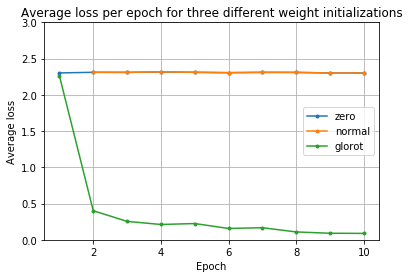

In [164]:
epochs = [1,2,3,4,5,6,7,8,9,10]
inits = ['zero','normal','glorot']
plt.figure(1)
plt.grid()
plt.ylim(0,3)
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.plot([1,2,3,4,5,6,7,8,9,10], NN_Mnist_zero.loss_train, marker = '.')
plt.plot([1,2,3,4,5,6,7,8,9,10], NN_Mnist_normal.loss_train, marker = '.')
plt.plot([1,2,3,4,5,6,7,8,9,10], NN_Mnist_glorot.loss_train, marker = '.')
plt.legend(inits)
plt.title('Average loss per epoch for three different weight initializations')
plt.show()

## Hyperparameter search

#### 1. Find a set of hyperparameters with validation accuracy over 97%

    -512 neurons on each hidden layer
    -learning rate schedule is 0.05 for first 7 epochs, 0.01 for the 8th, 0.003 for the last 2. 
    -ReLu activation function
    -Gradient norm cutoff is 1e-6
    -Number of epochs where valid_error increases before early stopping occurs is 3 in a row
    -Minibatch of size 10


In [230]:
#successful MLP: valid error is _____ missclassification and test error is ______
np.random.seed(123)
NN_Mnist = NN(784,512,512,10)

first = time.time()
NN_Mnist.train(X_train, y_train, 10, eta=0.05, max_ite = 50000 , epsilon=1e-12, print_loss=True, \
               X_valid = X_valid, Y_valid= Y_valid, X_test = X_test, Y_test = y_test, \
               lamb = ((0,0.00005),(0,0.00005),(0,0.00005)), print_graphs=True, initialization = 'glorot')

Missclassification rate after epoch  0.0  :  0.86562
Average loss after epoch  0.0  :  2.313954007504873
Missclassification rate after epoch  1.0  :  0.10664
Average loss after epoch  1.0  :  0.4084078644699645
Missclassification rate after epoch  2.0  :  0.06588
Average loss after epoch  2.0  :  0.23433235945160294
Missclassification rate after epoch  3.0  :  0.05908
Average loss after epoch  3.0  :  0.21193338830123462
Missclassification rate after epoch  4.0  :  0.05862
Average loss after epoch  4.0  :  0.21983803436223964
Missclassification rate after epoch  5.0  :  0.04292
Average loss after epoch  5.0  :  0.14553325499978245
Missclassification rate after epoch  6.0  :  0.04712
Average loss after epoch  6.0  :  0.16914304936719124
Missclassification rate after epoch  7.0  :  0.03182
Average loss after epoch  7.0  :  0.10932588299760193
Missclassification rate after epoch  8.0  :  0.02664
Average loss after epoch  8.0  :  0.08872028194973433
Missclassification rate after epoch  9.0

### Greedy search
First we find the optimal stepsize with no regularization. Each tuple contains the r_valid and the hyperparameter that was tested.

In [19]:
stepsizes = [1,1e-1,1e-2,1e-3]
r_valids = []
for i in range(len(stepsizes)):
    NN_Mnist_tune = NN(784,512,512,10)
    NN_Mnist_tune.train(X_train, y_train, 10, eta=stepsizes[i], max_ite = 50000 , epsilon=1e-6, print_loss=False, \
                        X_valid = X_valid, Y_valid= Y_valid, X_test = X_test, Y_test = y_test, \
                        print_graphs=True, initialization = 'glorot')

    r_valids.append((NN_Mnist_tune.compute_missclass(X_valid,Y_valid),stepsizes[i]))

print(r_valids)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in square


Missclassification ratio on training set88.644 %
Missclassification ratio on validation set89.36 %
Missclassification ratio on training set1.8739999999999999 %
Missclassification ratio on validation set2.5100000000000002 %
Missclassification ratio on training set4.2700000000000005 %
Missclassification ratio on validation set4.31 %
Missclassification ratio on training set7.166 %
Missclassification ratio on validation set6.529999999999999 %
[(0.8936, 1), (0.0251, 0.1), (0.0431, 0.01), (0.0653, 0.001)]


Best stepsize is 0.1, with a validation accuracy of over 97%. We could stop here considering the assignment's goal, but we proceed for pedagogical purposes. We test for values around this within the same order of magnitude.

In [31]:
stepsizes2 = [0.5,0.1,0.05]
r_valids_2 = []
for i in range(len(stepsizes2)):    
    NN_Mnist_tune = NN(784,512,512,10)
    NN_Mnist_tune.train(X_train, y_train, 10, eta=stepsizes[i], max_ite = 50000 , epsilon=1e-6, print_loss=False,\
                        X_valid = X_valid, Y_valid= Y_valid, X_test = X_test, Y_test = y_test, \
                        print_graphs=True, initialization = 'glorot')

    r_valids_2.append((NN_Mnist_tune.compute_missclass(X_valid,Y_valid),stepsizes2[i]))

print(r_valids_2)

Missclassification ratio on training set88.644 %
Missclassification ratio on validation set89.36 %
Missclassification ratio on training set1.8780000000000001 %
Missclassification ratio on validation set2.6100000000000003 %
Missclassification ratio on training set4.314 %
Missclassification ratio on validation set4.35 %
[(0.8936, 0.5), (0.0261, 0.1), (0.0435, 0.05)]


Best stepsize is 0.1. Add decreasing regime of stepsizes for later iterations(hardcoded into class).

Find best lambda for l2 regularization. l1 regularization is coded but not used.

In [33]:
lambdas = [((0,0.1),(0,0.1),(0,0.1)),((0,0.001),(0,0.001),(0,0.001)),((0,0.0001),(0,0.0001),(0,0.0001))]
r_valids_3 = []
for i in range(len(lambdas)):
    NN_Mnist_tune = NN(784,512,512,10)
    NN_Mnist_tune.train(X_train, y_train, 10, eta=0.1, max_ite = 50000 , epsilon=1e-6, print_loss=False, \
                        X_valid = X_valid, Y_valid= Y_valid, X_test = X_test, Y_test = y_test, \
                        lamb = lambdas[i], print_graphs=True, initialization = 'glorot')

    r_valids_3.append((NN_Mnist_tune.compute_missclass(X_valid,Y_valid),lambdas[i]))

print(r_valids_3)

Exit to avoid overfit
Missclassification ratio on training set78.86800000000001 %
Missclassification ratio on validation set77.63 %
Missclassification ratio on training set5.04 %
Missclassification ratio on validation set4.33 %
Missclassification ratio on training set2.2159999999999997 %
Missclassification ratio on validation set2.82 %
[(0.7763, ((0, 0.1), (0, 0.1), (0, 0.1))), (0.0433, ((0, 0.001), (0, 0.001), (0, 0.001))), (0.0282, ((0, 0.0001), (0, 0.0001), (0, 0.0001)))]


Best lambda is 0.0001. So far, best value of lambda is 0.

## Validate Gradients using Finite Differences

### 5 different values of N = 1/epsilon

In [71]:
np.random.seed(111)

NN_Mnist = NN(784,512,512,10)
NN_Mnist.initialize_weights(initialization = 'glorot')
NN_Mnist.forward(X_train[150].reshape(-1,1).T)
NN_Mnist.backward(X_train[150].reshape(-1,1).T, y_train[150].reshape(-1,1).T)

finite_differences = []
for i in range(5):
    finite_differences.append(NN_Mnist.finite_differences(X_train[150],y_train[150], epsilon = 1/((5)*10**(i))))
finite_differences = np.array(finite_differences)

import pandas as pd
row_labels = ['N = 5','N = 50','N = 500','N = 5000','N = 50000']
column_labels = []
pd.DataFrame(finite_differences, index = row_labels)

,0,1,2,3,4,5,6,7,8,9
N = 5,0.0,-0.037353,-0.015902,-0.017209,-0.006171,-0.016126,0.0,-0.029403,0.0,-0.021234
N = 50,0.0,-0.046870,-0.015902,-0.017209,-0.006171,-0.016126,0.0,-0.030808,0.0,-0.021234
N = 500,0.0,-0.046870,-0.015902,-0.017209,-0.006171,-0.016126,0.0,-0.030808,0.0,-0.021234
N = 5000,0.0,-0.046870,-0.015902,-0.017209,-0.006171,-0.016126,0.0,-0.030808,0.0,-0.021234
N = 50000,0.0,-0.046870,-0.015902,-0.017209,-0.006171,-0.016126,0.0,-0.030808,0.0,-0.021234


### Plot max differences as a function of N

In [72]:
max_differences = np.max(np.abs(finite_differences - NN_Mnist.dW2[0][0:10]), axis = 1)

<h3 align="center"> Plot of $ \left(\max_{1\leq i \leq p} | \nabla_i^N - \frac{\partial L}{\partial \theta_i}| \right)$ as a function of N <h3>

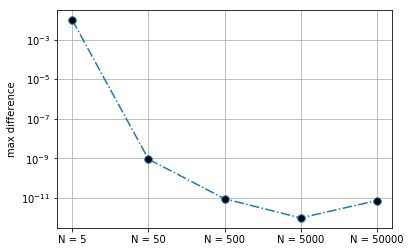

In [115]:
plt.figure(1)
plt.yscale('log')
plt.ylabel('max difference')
plt.grid()
plt.plot(row_labels, max_differences, '-.', marker = '.', ms = '15', mfc = 'black')